#Integrated Gradients

This Jupyter Notebook demonstrates how to apply Explainable AI techniques to pre-trained deep learning models for object detection, using the Captum library and PyTorch's models.

Library Imports & Model Preparation: The notebook starts by importing the necessary Python libraries and loading pre-trained ResNet-50 and Faster R-CNN models for image classification and object detection, respectively.

Image Preparation & Object Detection: An image is loaded, transformed, and passed through the Faster R-CNN model to identify the pedestrian with the highest confidence score.

Image Classification & XAI: The identified pedestrian is cropped from the image, transformed, and fed into the ResNet-50 model for classification. The Captum library is then used to apply the Integrated Gradients method, highlighting the pixels that most influenced the model's classification decision.

Attribution Visualization: Finally, the notebook visualizes the Integrated Gradients attributions alongside the original image, providing an insightful view into the model's decision-making process.

This Jupyter notebook is based on:

* https://captum.ai/tutorials/CIFAR_TorchVision_Interpret  
* https://captum.ai/tutorials/Resnet_TorchVision_Interpret
* https://captum.ai/docs/attribution_algorithms#integrated-gradients
* http://arxiv.org/abs/1703.01365


#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [2]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [1]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using Integrated Gradients
This cell imports necessary libraries and uses Faster R-CNN and ResNet-50 models (both pretrained) to detect and classify a pedestrian in an image. The Captum library's Integrated Gradients method is then employed to illustrate influential pixels in the decision-making process. Lastly, it visualizes the generated attributions alongside the original image for deeper understanding.

Using device: cpu
1
[ 43.014244  25.059769 184.35086  255.90811 ]
0.99955124


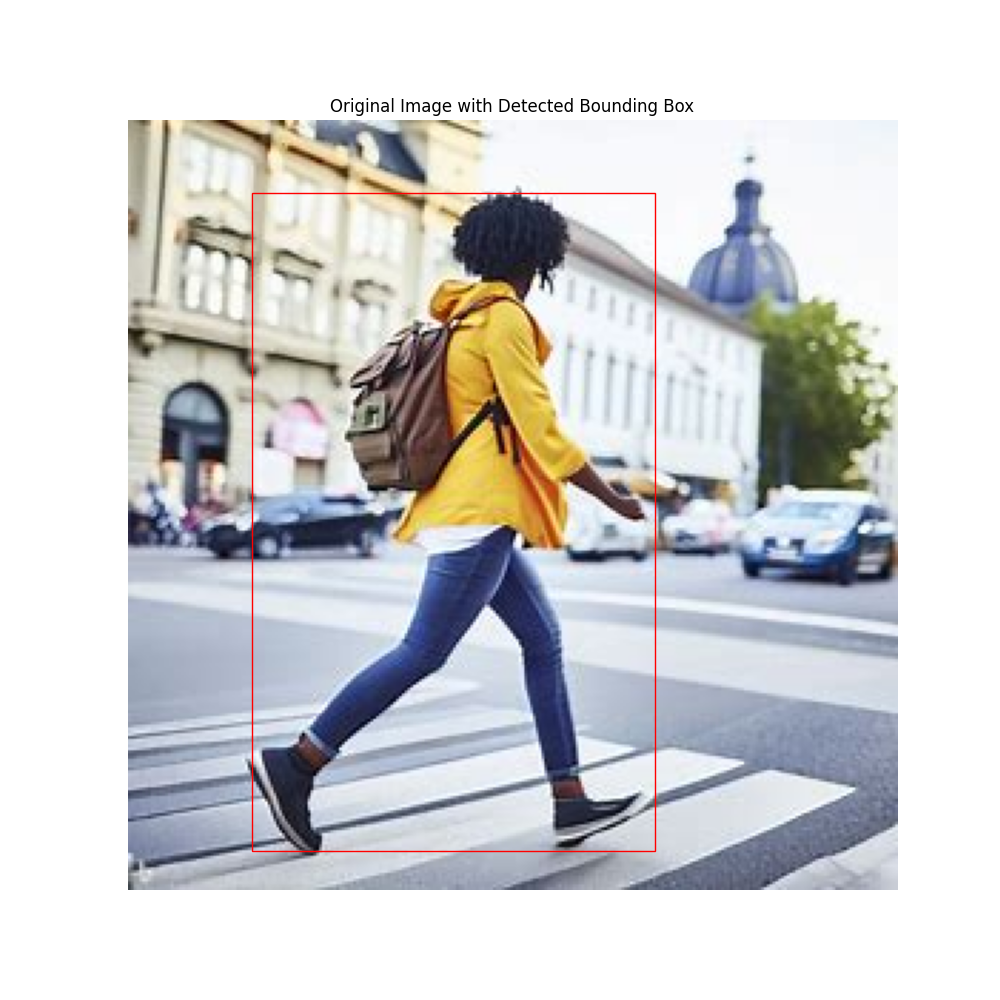

Label Index: 880, Probability: 28.67%


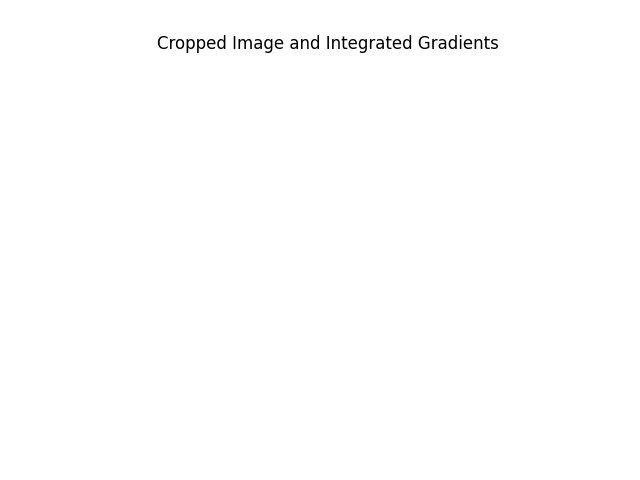

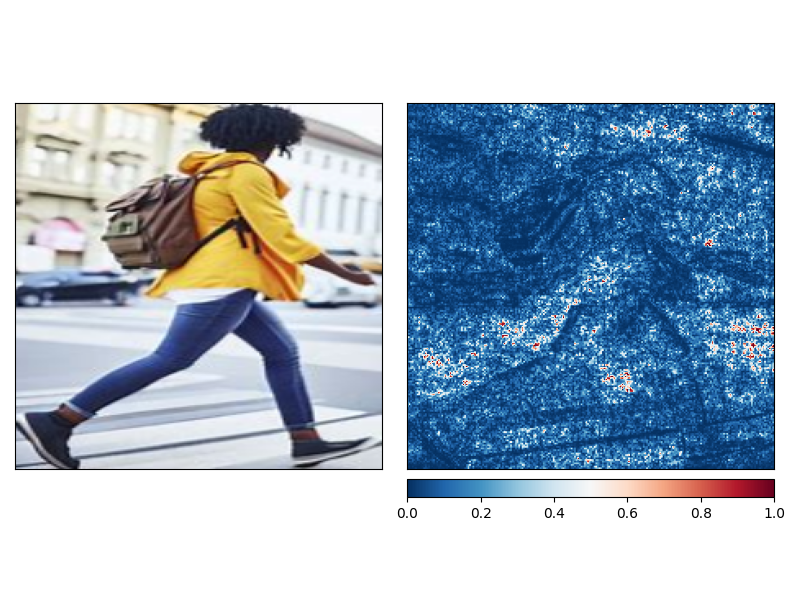

In [3]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet50
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from captum.attr import IntegratedGradients, visualization as viz
import torch.nn.functional as F

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Load the pre-trained ResNet-50 model for classification
classification_model = resnet50(pretrained=True)
classification_model.to(device)
classification_model.eval()

# Load the pre-trained Faster R-CNN model for object detection
detection_model = fasterrcnn_resnet50_fpn(pretrained=True)
detection_model.to(device)
detection_model.eval()

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Open the image
img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/pedestrian.jpg')

input_img = transform(img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)

# Run the image through the detection model to get predictions
with torch.no_grad():
    predictions = detection_model(input_img)

# Get the predicted bounding boxes, labels, and scores
predicted_boxes = predictions[0]['boxes'].cpu().numpy()
predicted_labels = predictions[0]['labels'].cpu().numpy()
predicted_scores = predictions[0]['scores'].cpu().numpy()

# Select only boxes with pedestrian label ( label id for pedestrian is 1)
indices = np.where(predicted_labels == 1)[0]
scores = predicted_scores[indices]

# Find the index of the bounding box with the highest score
best_index = indices[scores.argmax()]

box = predicted_boxes[best_index]
label = predicted_labels[best_index]
score = predicted_scores[best_index]

print(label)
print(box)
print(score)

# Plot original image with the bounding box
plt.figure(figsize=(10,10))
plt.imshow(img)
rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red')
plt.gca().add_patch(rect)
plt.axis('off')
plt.title('Original Image with Detected Bounding Box')
plt.show()

# Crop the image based on the bounding box
cropped_img = img.crop((box[0], box[1], box[2], box[3]))

# Resize and normalize the cropped image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cropped_input = transform(cropped_img).unsqueeze(0).to(device)

# Run the cropped image through the classification model to get predictions
with torch.no_grad():
    class_predictions = classification_model(cropped_input)

outputs = classification_model(cropped_input)
output_probs = F.softmax(outputs, dim=1).squeeze(0)
# Find the index of the maximum value
label_idx = output_probs.argmax()
# Get the corresponding probability
probability = output_probs[label_idx].item() * 100 # converting to percentage
print(f"Label Index: {label_idx}, Probability: {probability:.2f}%")


# Define Integrated Gradients
integrated_gradients = IntegratedGradients(classification_model)

# Calculate integrated gradients
attributions_ig = integrated_gradients.attribute(cropped_input, target=class_predictions.argmax(dim=1).item(), n_steps=10)

# Normalize the integrated gradients
attributions_ig = attributions_ig / torch.norm(attributions_ig)

# define the mean and standard deviation
mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

# denormalize the tensor
denormalized_input = cropped_input * std + mean

plt.axis('off')
plt.title('Cropped Image and Integrated Gradients')

# visualize the integrated gradients
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                    np.transpose(denormalized_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                                    ["original_image", "heat_map"],
                                                    ["all", "absolute_value"],
                                                    cmap='RdBu_r',
                                                    show_colorbar=True)


#### XAI metrics

A low infidelity value close to 0 indicates that the explanation provided by the XAI method is relatively faithful to the model's behavior. It suggests that the generated explanation is a good representation of how the model arrived at its predictions, making it a reliable and accurate explanation.

A high sensitivity value indicates that the model is highly sensitive to changes in specific input features. In other words, small changes in those features can lead to substantial changes in the model's predictions. This suggests that the model heavily relies on the identified features to make its decisions.

In [ ]:
from captum.metrics import infidelity, sensitivity_max
import numpy as np

# Define the perturbation function
def perturb_fn(inputs):
    # Multiplying by 0.003 scales the random values to control the magnitude of the perturbations.
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
    return noise, inputs - noise

# Compute the infidelity
infid = infidelity(classification_model, perturb_fn, cropped_input, attributions_ig, target=class_predictions.argmax(dim=1).item())

print(f"Infidelity: {infid.item()}")

# Wrapper function
def ig_attr(inputs):
    return integrated_gradients.attribute(inputs, target=class_predictions.argmax(dim=1).item(), n_steps=10)

# Calculate Sensitivity
sens = sensitivity_max(ig_attr, cropped_input)
print(f"Sensitivity: {sens.item()}")

Infidelity: 0.00011136228534038201
Sensitivity: 0.6399681145178827
